# Brain Tumor Detection using CNN with Pytorch

## Installation Note

The libraries in the following cell, i.e. numpy, matplotlib, torch, torchvision, Image, etc., need to be installed for this notebook to run.

In [1]:
# !pip install torch torchvision

In [2]:
import torch
print(torch.__version__)

2.4.1+cpu


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import torch
from PIL import Image
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
import torch.nn.functional as F
import pathlib
from torch import optim

## Loading data and preprocessing

In [4]:
os.listdir('data')

['Brain Tumor', 'Healthy']

In [5]:
data_dir = 'data'
data_dir = pathlib.Path(data_dir)

In [6]:
splitfolders.ratio(data_dir, output='splitted-data', seed=41, ratio=(0.8, 0.2))

Copying files: 4600 files [00:24, 191.65 files/s]


In [10]:
# storing the updated path of the train-test split data
data_dir = 'splitted-data'
data_dir = pathlib.Path(data_dir)

### Data Augmentation

In [11]:
# Transforming the images, i.e. standardising the sizes, etc
transform = transforms.Compose(
    [
        transforms.Resize((128,128)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [12]:
# performing all the transformations with the training and validation datasets
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath('train'), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath('val'), transform=transform)
val_set.transform

Compose(
    Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [13]:
print (train_set)

Dataset ImageFolder
    Number of datapoints: 3679
    Root location: splitted-data\train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [14]:
print (val_set)

Dataset ImageFolder
    Number of datapoints: 921
    Root location: splitted-data\val
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [15]:
# to check class to index mapping
print(train_set.class_to_idx)

{'Brain Tumor': 0, 'Healthy': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


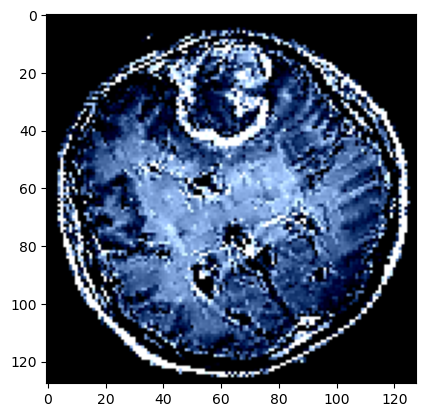

In [16]:
img, label = train_set[500]
plt.imshow(img.permute(1,2,0))

In [17]:
batch_size = 64
# Loaders to create batches
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [18]:
# shape of (val) loader:  [batch size, dimensions of the image(RGB), Image size 128x128 rows and columns]
next(iter(val_loader))[0].shape

torch.Size([64, 3, 128, 128])

## Network Architecture

In [19]:
class CNNModel(nn.Module):  
  def __init__(self):
    super(CNNModel, self).__init__()

    #Conv 1
    self.cnv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) #128-5+1=124

    #Max Pool 1
    self.maxpool1 = nn.MaxPool2d(kernel_size=2) #124/2 = 64

    #Conv 2
    self.cnv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) #60

    #Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size=2) #30

    #Conv 3
    self.cnv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) #26

    #Max Pool 3
    self.maxpool3 = nn.MaxPool2d(kernel_size=2) #13

    #Conv 4
    self.cnv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=0) #9

    #Max Pool 4
    self.maxpool4 = nn.MaxPool2d(kernel_size=2) #4

    #Activation Function
    self.leakyRelu = nn.LeakyReLU()

    #Fully connected Layer 1
    self.fc1 = nn.Linear(128*4*4, 1024)

    #Fully connected Layer 2
    self.fc2 = nn.Linear(1024, 2)
      
  #forward propagation      
  def forward(self, x):
        
    #Layer 1 
    # (the features are passed to the 1st conv layer, then passed the output to LeakyRelu and then output through 1st Maxpool layer)
    # The output of one layer acts as input to the next layer
      
    out = self.leakyRelu(self.cnv1(x))
    out = self.maxpool1(out)

    #Layer 2
    out = self.leakyRelu(self.cnv2(out))
    out = self.maxpool2(out)

    #Layer 3
    out = self.leakyRelu(self.cnv3(out))
    out = self.maxpool3(out)

    #Layer 4
    out = self.leakyRelu(self.cnv4(out))
    out = self.maxpool4(out)

    #flatten
    out = out.view(out.size(0), -1)

    # here the output of the 4th layer acts as an input to the first fully-connected layer fc1
    # Linear Function
    out = self.leakyRelu(self.fc1(out))
    # here the output of the first fully-connected layer fc1 is input to 2nd fully-connected layer fc2 which is actually an output layer
    out = self.fc2(out)

    return out

## Training CNN

In [20]:
num_epochs = 10
model = CNNModel()
error = nn.CrossEntropyLoss()

#learning rate is 0.001, but it will be updated based on the ReduceLROnPlateau method below.
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [21]:
#Lists to store the metrics results
train_loss_list = []
val_loss_list = []
accuracy_list = []

for epoch in range(num_epochs):
  train_loss = 0
  val_loss = 0
  # iterating over each training loader
  for i, (images, labels) in enumerate(train_loader):

    optimizer.zero_grad()
    # Inside each loader, we send the images to the model
    outputs = model(images)
    # checking the loss
    loss = error(outputs, labels)
    train_loss+=loss.item()
    # based on the loss back propagation is performed to adjust all weights accordingly
    loss.backward()
    optimizer.step()
    print("Loss in Iteration:", i, ":", loss.item())
  
  # checking how the model performs on the validation set based on 1 epoch of training on the training set
  total = 0
  correct = 0
  for images, labels in val_loader:
    outputs = model(images)
    v_loss = error(outputs, labels)
    val_loss+=v_loss.item()
    predicted = torch.max(outputs.data, 1)[1]

    total+=len(labels)
    # keeping accuracy in the following variable
    correct+=(predicted==labels).sum()

# outputting all metrics after each epoch
  scheduler.step(val_loss/len(val_loader))
  accuracy = 100*correct/float(total)
  train_loss_list.append(train_loss/len(train_loader))
  val_loss_list.append(val_loss/len(val_loader))
  accuracy_list.append(accuracy)
  print("Epoch:{}  Loss:{}  Accuracy:{}%".format(epoch, train_loss/len(train_loader), accuracy))

Loss in Iteration: 0 : 0.6926106810569763
Loss in Iteration: 1 : 0.6881272792816162
Loss in Iteration: 2 : 0.6915779113769531
Loss in Iteration: 3 : 0.6877568364143372
Loss in Iteration: 4 : 0.6952093243598938
Loss in Iteration: 5 : 0.6850250959396362
Loss in Iteration: 6 : 0.6929426789283752
Loss in Iteration: 7 : 0.6805787682533264
Loss in Iteration: 8 : 0.688270628452301
Loss in Iteration: 9 : 0.6776787042617798
Loss in Iteration: 10 : 0.6459542512893677
Loss in Iteration: 11 : 0.6506778001785278
Loss in Iteration: 12 : 0.6578199863433838
Loss in Iteration: 13 : 0.6166164875030518
Loss in Iteration: 14 : 0.7659224271774292
Loss in Iteration: 15 : 0.6962380409240723
Loss in Iteration: 16 : 0.6414083242416382
Loss in Iteration: 17 : 0.7481464743614197
Loss in Iteration: 18 : 0.6117311120033264
Loss in Iteration: 19 : 0.6508703231811523
Loss in Iteration: 20 : 0.645921528339386
Loss in Iteration: 21 : 0.6222994923591614
Loss in Iteration: 22 : 0.635625958442688
Loss in Iteration: 23 : 

In [22]:
torch.save(model.state_dict(), 'cnn_model.pth')

## Analysis of the Results

In [23]:
train_loss_list

[0.5996279099891926,
 0.4604042624605113,
 0.36364623313320094,
 0.2870580217447774,
 0.22337407323307004,
 0.17826534236042663,
 0.15762384274396404,
 0.143569462579386,
 0.1366588305681944,
 0.1130359670275758]

In [24]:
val_loss_list

[0.48076617320378623,
 0.44405974944432575,
 0.27251479427019754,
 0.2340044637521108,
 0.18561113973458607,
 0.17402899861335755,
 0.14306280128657817,
 0.10915315821766854,
 0.15895573248465855,
 0.096818599725763]

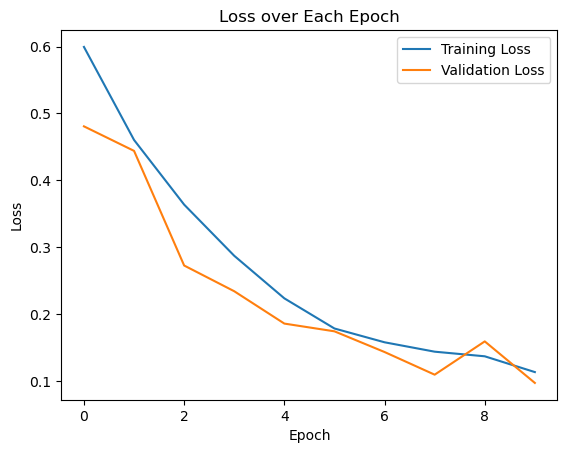

In [25]:
plt.plot(range(num_epochs), train_loss_list, label='Training Loss')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss')
plt.title('Loss over Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
accuracy_list

[tensor(77.1987),
 tensor(80.0217),
 tensor(89.5765),
 tensor(90.6623),
 tensor(93.7025),
 tensor(93.1596),
 tensor(95.0054),
 tensor(96.5255),
 tensor(94.5711),
 tensor(96.4169)]

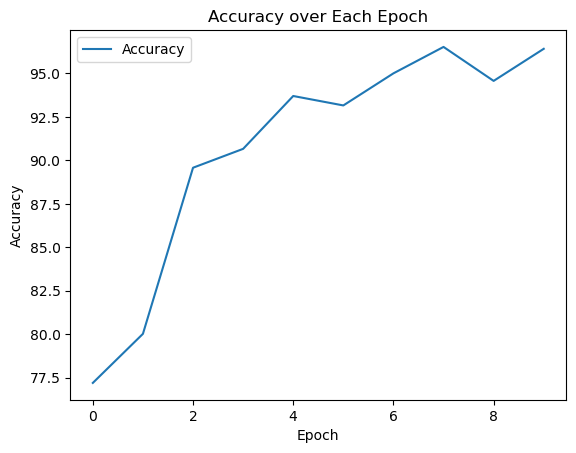

In [27]:
plt.plot(range(num_epochs), accuracy_list, label='Accuracy')
plt.title('Accuracy over Each Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '0')

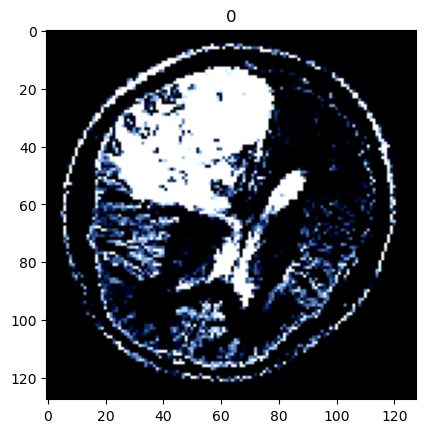

In [28]:
# picking any image from dataset for testing
img, label = val_set[100]
plt.imshow(img.permute(1,2,0))
plt.title(label)

In [29]:
# giving the above image to the model and comparing the prediction with the actual label {'Brain Tumor': 0, 'Healthy': 1}
image = img.unsqueeze(0)

with torch.no_grad():
  output = model(image)

_, pred = torch.max(output, 1)
print("Predicted Output:", pred.item())

Predicted Output: 0
